In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39715 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
db = '/g/data/e14/rmh561/access-om2/archive/databases/cc_database_nostress.db'
session = cc.database.create_session(db)
expt = ['025deg_jra55_ryf_nostress_cont','025deg_jra55_ryf_nostress']
names = {'025deg_jra55_ryf_nostress_cont':'Control','025deg_jra55_ryf_nostress':'No Stress'}

### 1. Barotropic Streamfunction

In [17]:
x_ACC = -70
y_min = -71.6
y_max = -51
tx_trans_int_z_con = cc.querying.getvar(expt[0],'tx_trans_int_z',session,start_time='1900-01-01', 
                       end_time='1919-12-31').sel(xu_ocean = x_ACC, method = 'nearest').sel(yt_ocean = slice(y_min,y_max))
ty_trans_int_z_con = cc.querying.getvar(expt[0],'ty_trans_int_z',session,start_time='1900-01-01', 
                       end_time='1919-12-31').sel(xt_ocean = x_ACC, method = 'nearest').sel(yu_ocean = slice(y_min,y_max))
tx_trans_int_z_buo = cc.querying.getvar(expt[1],'tx_trans_int_z',session,start_time='1900-01-01', 
                       end_time='1919-12-31').sel(xu_ocean = x_ACC, method = 'nearest').sel(yt_ocean = slice(y_min,y_max))
ty_trans_int_z_buo = cc.querying.getvar(expt[1],'ty_trans_int_z',session,start_time='1900-01-01', 
                       end_time='1919-12-31').sel(xt_ocean = x_ACC, method = 'nearest').sel(yu_ocean = slice(y_min,y_max))

Text(0.5, 1.0, 'Barotropic Transport')

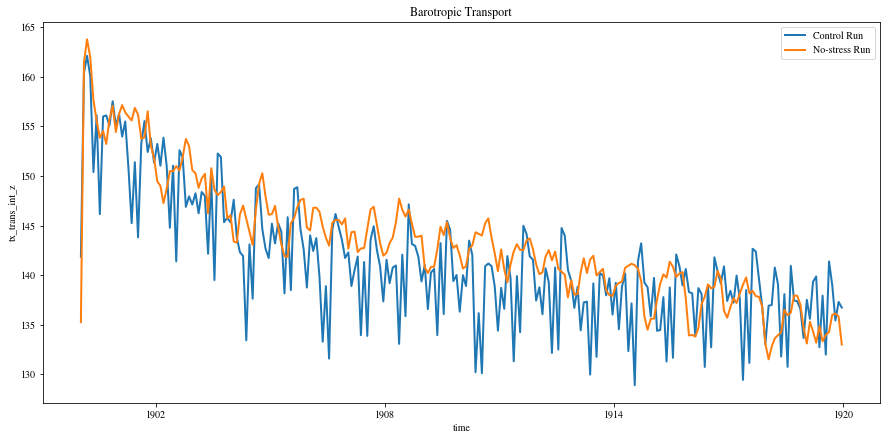

In [91]:
rho0=1035
psi_con = tx_trans_int_z_con.sum('yt_ocean')/(rho0*1.e6)
psi_buo = tx_trans_int_z_buo.sum('yt_ocean')/(rho0*1.e6)

plt.figure(figsize=(15,7))

psi_con.plot(label = 'Control Run')
psi_buo.plot(label = 'No-stress Run')
plt.legend()
plt.title('Barotropic Transport')

### 2. Stratification

In [25]:
start_time = '1919-01-01'
end_time = '1919-12-31'
salt_con = cc.querying.getvar(expt[0],'salt',session,start_time='1919-01-01',end_time='1919-12-31').sel(
    xt_ocean = x_ACC, method = 'nearest').sel(yt_ocean = slice(y_min,y_max)).sel(time = slice(start_time,end_time))
salt_buo = cc.querying.getvar(expt[1],'salt',session,start_time='1919-01-01',end_time='1919-12-31').sel(
    xt_ocean = x_ACC, method = 'nearest').sel(yt_ocean = slice(y_min,y_max)).sel(time = slice(start_time,end_time))

In [30]:
salt_con_Jan = salt_con.sel(time = slice('1919-01-01','1919-01-31')).mean('time')
salt_buo_Jan = salt_buo.sel(time = slice('1919-01-01','1919-01-31')).mean('time')

Text(0.5, 1.0, 'Ocean depth')

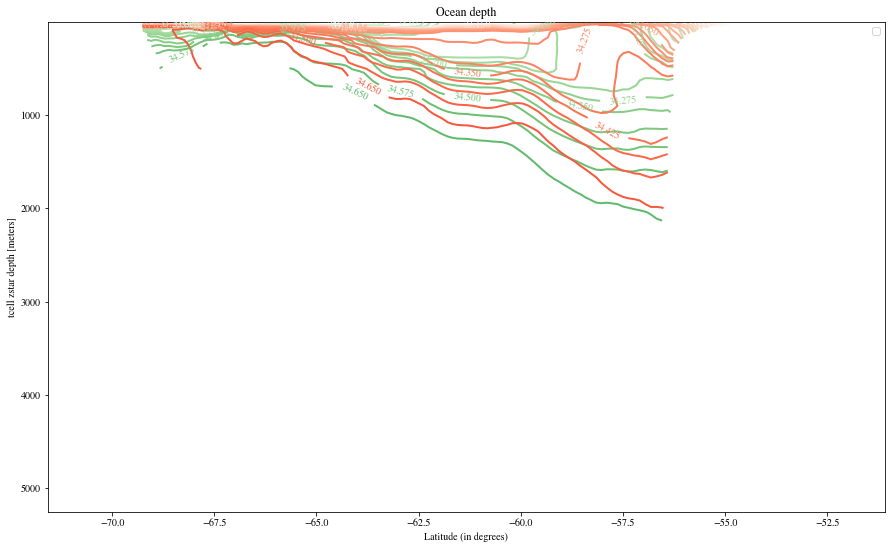

In [66]:
plt.figure(figsize=(15,9))

test_1 = salt_con_Jan.plot.contour(levels = np.linspace(33,36,41),cmap = 'Greens')
#test = salt_con_Jan.plot.contourf(levels = np.linspace(32,36,41))
plt.gca().invert_yaxis()
plt.clabel(test_1, inline=True,fontsize=10)

test_2 = salt_buo_Jan.plot.contour(levels = np.linspace(33,36,41),cmap = 'Reds')
#test = salt_buo_Jan.plot.contourf(levels = np.linspace(30,36,21),cmap = 'Reds')
plt.gca().invert_yaxis()
plt.clabel(test_2, inline=True,fontsize=10)

plt.xlabel('Latitude (in degrees)')
plt.legend([test_1,test_2],['Control Run','No-stress Run'])
plt.title('Ocean depth')

### 3. Velocity Shear

In [67]:
u_con = cc.querying.getvar(expt[0],'u',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-u-1-monthly-mean-ym_%.nc',
                       end_time='1919-12-31').sel(xu_ocean = slice(-72,-68)).sel(yu_ocean = slice(y_min,y_max))
v_con = cc.querying.getvar(expt[0],'v',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-v-1-monthly-mean-ym_%.nc',
                       end_time='1919-12-31').sel(xu_ocean = slice(-72,-68)).sel(yu_ocean = slice(y_min,y_max))
u_buo = cc.querying.getvar(expt[1],'u',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-u-1-monthly-mean-ym_%.nc',
                       end_time='1919-12-31').sel(xu_ocean = slice(-72,-68)).sel(yu_ocean = slice(y_min,y_max))
v_buo = cc.querying.getvar(expt[1],'v',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-v-1-monthly-mean-ym_%.nc',
                       end_time='1919-12-31').sel(xu_ocean = slice(-72,-68)).sel(yu_ocean = slice(y_min,y_max))

In [69]:
ushear_con = u_con.sel(time = slice('1901-01-01','1919-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')
ushear_buo = u_buo.sel(time = slice('1901-01-01','1919-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')
vshear_con = v_con.sel(time = slice('1901-01-01','1919-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')
vshear_buo = v_buo.sel(time = slice('1901-01-01','1919-12-31')).differentiate('st_ocean').mean('xu_ocean').mean('yu_ocean')

Text(0.5, 1.0, 'Velocity Shear - Year 1901')

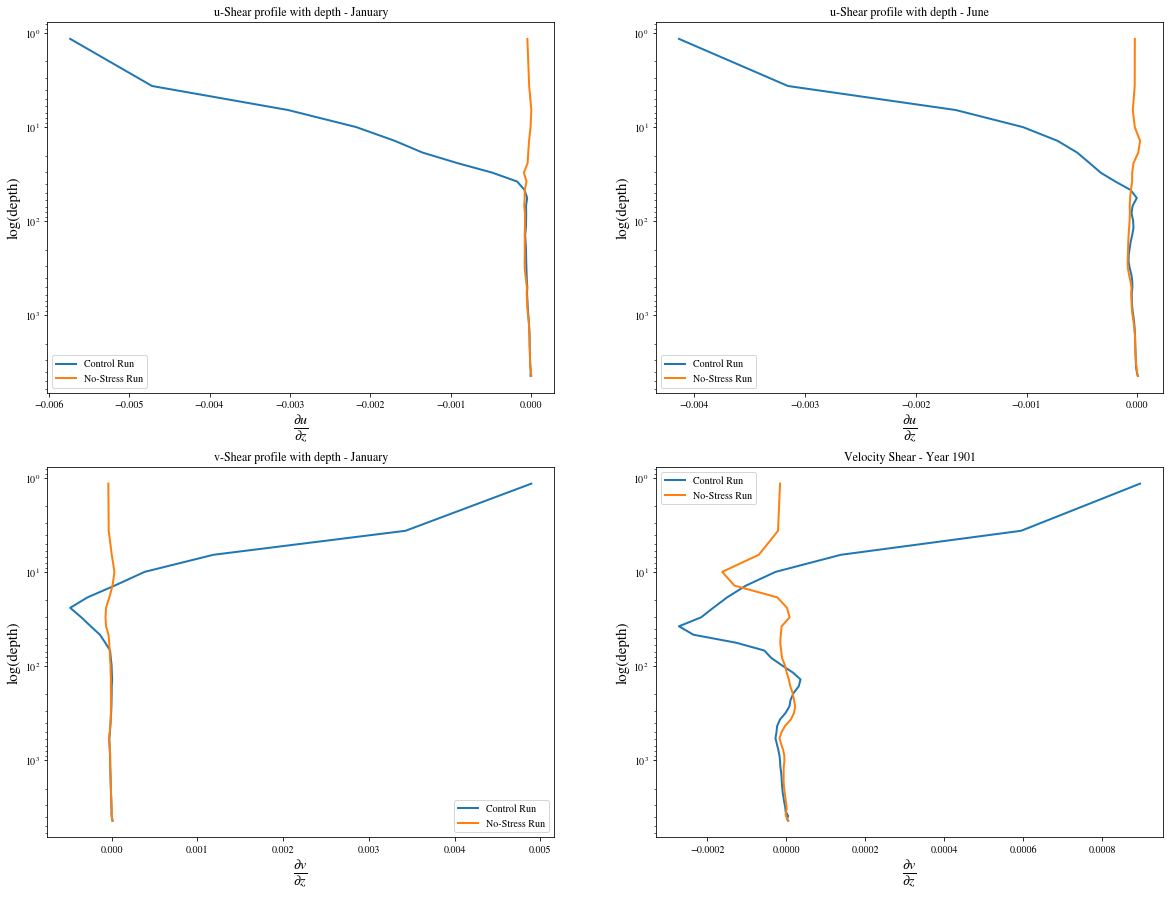

In [81]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

#plt.gca().invert_yaxis()
axes[0][0].invert_yaxis()
axes[0][0].set_yscale("log")
ushear_con.sel(time = slice('1901-01-01','1901-01-31')).mean('time').plot(y = 'st_ocean',ax = axes[0][0],label='Control Run')
ushear_buo.sel(time = slice('1901-01-01','1901-01-31')).mean('time').plot(y = 'st_ocean',ax = axes[0][0],label='No-Stress Run')
axes[0][0].set_xlabel(r'$\frac{\partial u}{\partial z}$',fontsize = 20)
axes[0][0].set_ylabel('log(depth)',fontsize = 15)
axes[0][0].set_title('u-Shear profile with depth - January')
axes[0][0].legend()

axes[0][1].invert_yaxis()
axes[0][1].set_yscale("log")
ushear_con.sel(time = slice('1901-06-01','1901-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][1],label='Control Run')
ushear_buo.sel(time = slice('1901-06-01','1901-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][1],label='No-Stress Run')
axes[0][1].set_xlabel(r'$\frac{\partial u}{\partial z}$',fontsize = 20)
axes[0][1].set_ylabel('log(depth)',fontsize = 15)
axes[0][1].set_title('u-Shear profile with depth - June')
axes[0][1].legend()

axes[1][0].invert_yaxis()
axes[1][0].set_yscale("log")
vshear_con.sel(time = slice('1901-01-01','1901-01-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][0],label='Control Run')
vshear_buo.sel(time = slice('1901-01-01','1901-01-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][0],label='No-Stress Run')
axes[1][0].set_xlabel(r'$\frac{\partial v}{\partial z}$',fontsize = 20)
axes[1][0].set_ylabel('log(depth)',fontsize = 15)
axes[1][0].set_title('v-Shear profile with depth - January')
axes[1][0].legend()

axes[1][1].invert_yaxis()
axes[1][1].set_yscale("log")
vshear_con.sel(time = slice('1901-06-01','1901-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][1],label='Control Run')
vshear_buo.sel(time = slice('1901-06-01','1901-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][1],label='No-Stress Run')
axes[1][1].set_xlabel(r'$\frac{\partial v}{\partial z}$',fontsize = 20)
axes[1][1].set_ylabel('log(depth)',fontsize = 15)
axes[1][1].set_title('v-Shear profile with depth - June')
axes[1][1].legend()

plt.title('Velocity Shear - Year 1901')

Text(0.5, 1.0, 'Velocity Shear - Year 1919')

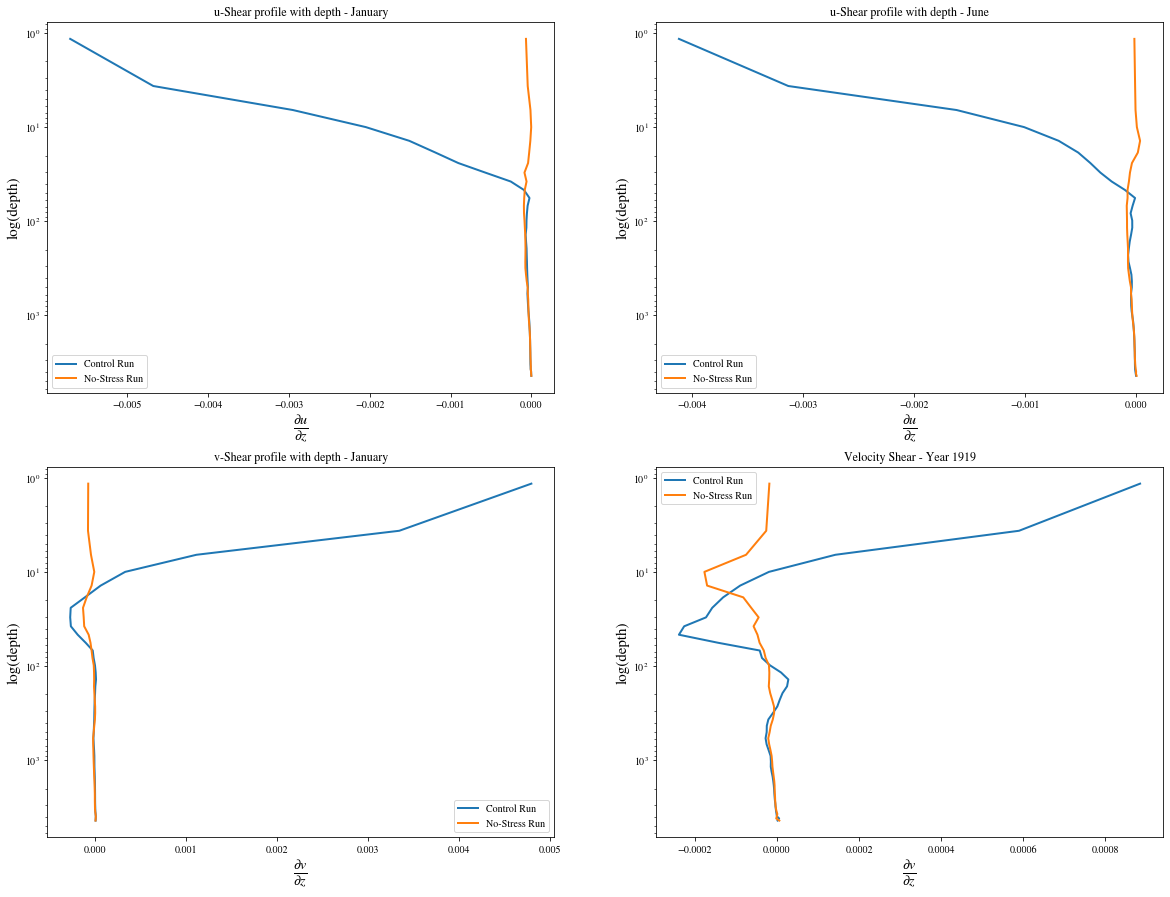

In [80]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

#plt.gca().invert_yaxis()
axes[0][0].invert_yaxis()
axes[0][0].set_yscale("log")
ushear_con.sel(time = slice('1919-01-01','1919-01-31')).mean('time').plot(y = 'st_ocean',ax = axes[0][0],label='Control Run')
ushear_buo.sel(time = slice('1919-01-01','1919-01-31')).mean('time').plot(y = 'st_ocean',ax = axes[0][0],label='No-Stress Run')
axes[0][0].set_xlabel(r'$\frac{\partial u}{\partial z}$',fontsize = 20)
axes[0][0].set_ylabel('log(depth)',fontsize = 15)
axes[0][0].set_title('u-Shear profile with depth - January')
axes[0][0].legend()

axes[0][1].invert_yaxis()
axes[0][1].set_yscale("log")
ushear_con.sel(time = slice('1919-06-01','1919-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][1],label='Control Run')
ushear_buo.sel(time = slice('1919-06-01','1919-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[0][1],label='No-Stress Run')
axes[0][1].set_xlabel(r'$\frac{\partial u}{\partial z}$',fontsize = 20)
axes[0][1].set_ylabel('log(depth)',fontsize = 15)
axes[0][1].set_title('u-Shear profile with depth - June')
axes[0][1].legend()

axes[1][0].invert_yaxis()
axes[1][0].set_yscale("log")
vshear_con.sel(time = slice('1919-01-01','1919-01-31')).mean('time').plot(y = 'st_ocean',ax = axes[1][0],label='Control Run')
vshear_buo.sel(time = slice('1919-01-01','1919-01-31')).mean('time').plot(y = 'st_ocean',ax = axes[1][0],label='No-Stress Run')
axes[1][0].set_xlabel(r'$\frac{\partial v}{\partial z}$',fontsize = 20)
axes[1][0].set_ylabel('log(depth)',fontsize = 15)
axes[1][0].set_title('v-Shear profile with depth - January')
axes[1][0].legend()

axes[1][1].invert_yaxis()
axes[1][1].set_yscale("log")
vshear_con.sel(time = slice('1919-06-01','1919-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][1],label='Control Run')
vshear_buo.sel(time = slice('1919-06-01','1919-06-30')).mean('time').plot(y = 'st_ocean',ax = axes[1][1],label='No-Stress Run')
axes[1][1].set_xlabel(r'$\frac{\partial v}{\partial z}$',fontsize = 20)
axes[1][1].set_ylabel('log(depth)',fontsize = 15)
axes[1][1].set_title('v-Shear profile with depth - June')
axes[1][1].legend()

plt.title('Velocity Shear - Year 1919')

### 4. Heat Flux

In [92]:
Qnet_con = cc.querying.getvar(expt=expt[0], variable='net_sfc_heating', session=session, frequency='1 monthly', start_time='1900-01-01', end_time='1919-12-31').sel(
    xt_ocean = x_ACC, method = 'nearest').sel(yt_ocean = slice(y_min,y_max))
Qnet_buo = cc.querying.getvar(expt=expt[1], variable='net_sfc_heating', session=session, frequency='1 monthly', start_time='1900-01-01', end_time='1919-12-31').sel(
    xt_ocean = x_ACC, method = 'nearest').sel(yt_ocean = slice(y_min,y_max))
area_t = cc.querying.getvar(expt=expt[0], variable='area_t', session=session, frequency='static', n=1).sel(
    xt_ocean = x_ACC, method = 'nearest').sel(yt_ocean = slice(y_min,y_max))

In [94]:
Qnet_avg_con = (Qnet_con*area_t).sum(dim = ['yt_ocean'])/area_t.sum(dim = ['yt_ocean'])
Qnet_avg_buo = (Qnet_buo*area_t).sum(dim = ['yt_ocean'])/area_t.sum(dim = ['yt_ocean'])

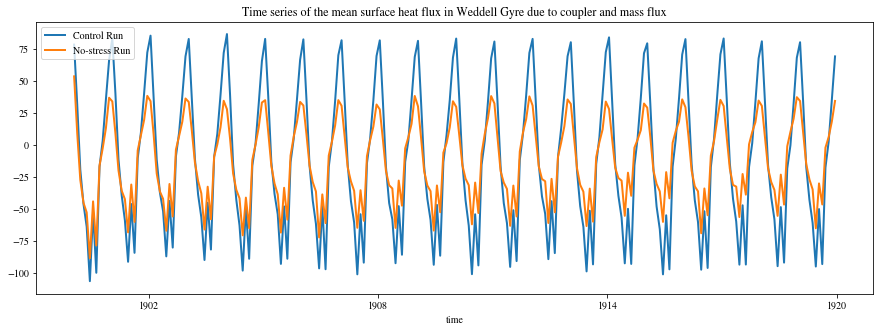

In [105]:
plt.figure(figsize=(15,5))
plt.subplot(111)
Qnet_avg_con.plot()
Qnet_avg_buo.plot()
plt.title('Time series of the mean surface heat flux due to coupler and mass flux')
plt.legend(['Control Run','No-stress Run']) 
plt.show()

In [121]:
vars_025deg = cc.querying.get_variables(session, experiment=expt[0])
vars_025deg[vars_025deg['name'].str.lower().str.match('tau')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
232,tau_x,i-directed wind stress forcing u-velocity,1 monthly,output009/ocean/ocean-2d-tau_x-1-monthly-mean-...,20,1900-01-01 00:00:00,1920-01-01 00:00:00
233,tau_y,j-directed wind stress forcing v-velocity,1 monthly,output009/ocean/ocean-2d-tau_y-1-monthly-mean-...,20,1900-01-01 00:00:00,1920-01-01 00:00:00


In [114]:
variable='frazil_3d_int_z'
frazil_con = cc.querying.getvar(expt[0], variable, session, frequency='1 monthly', start_time='1900-01-01', end_time='1919-12-31',decode_coords=False)
frazil_buo = cc.querying.getvar(expt[1], variable, session, frequency='1 monthly', start_time='1900-01-01', end_time='1919-12-31',decode_coords=False)
area_t = cc.querying.getvar(expt='025deg_jra55_ryf_nostress', variable='area_t', session=session, frequency='static', n=1)

frazil_avg_con = (frazil_con*area_t).sum(dim = ['xt_ocean','yt_ocean'])/area_t.sum(dim = ['xt_ocean','yt_ocean'])
frazil_avg_buo = (frazil_buo*area_t).sum(dim = ['xt_ocean','yt_ocean'])/area_t.sum(dim = ['xt_ocean','yt_ocean'])

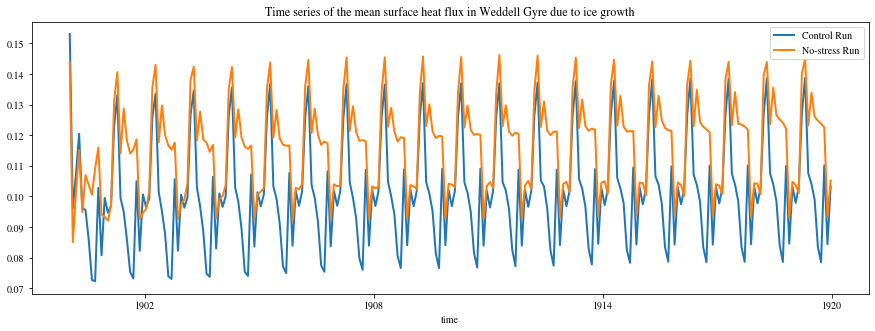

In [115]:
plt.figure(figsize=(15,5))
plt.subplot(111)
frazil_avg_con.plot()
frazil_avg_buo.plot()
plt.title('Time series of the mean surface heat flux due to ice growth')
plt.legend(['Control Run','No-stress Run']) 
plt.show()

### 5. Surface Stress

In [136]:
tau_x_con = cc.querying.getvar(expt[0],'tau_x',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = x_ACC, method = 'nearest').sel(yu_ocean = slice(y_min,y_max))
tau_y_con = cc.querying.getvar(expt[0],'tau_y',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = x_ACC, method = 'nearest').sel(yu_ocean = slice(y_min,y_max))
tau_x_buo = cc.querying.getvar(expt[1],'tau_x',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = x_ACC, method = 'nearest').sel(yu_ocean = slice(y_min,y_max))
tau_y_buo = cc.querying.getvar(expt[1],'tau_y',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = x_ACC, method = 'nearest').sel(yu_ocean = slice(y_min,y_max))

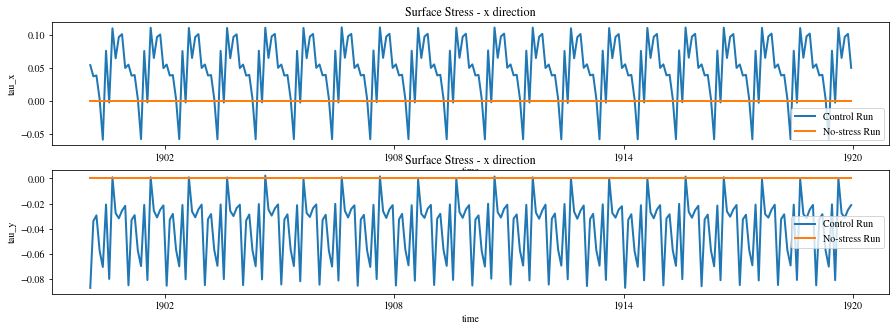

In [138]:
plt.figure(figsize=(15,5))
plt.subplot(211)
tau_x_con.mean('yu_ocean').plot()
tau_x_buo.mean('yu_ocean').plot()
plt.title('Surface Stress - x direction')
plt.legend(['Control Run','No-stress Run']) 

plt.subplot(212)
tau_y_con.mean('yu_ocean').plot()
tau_y_buo.mean('yu_ocean').plot()
plt.title('Surface Stress - x direction')
plt.legend(['Control Run','No-stress Run']) 
plt.show()

### Summarising here:

1. There is nothing to talk about the streamfunction as of now. The runs for the next 40 years will be completed by tomorrow, so I'll come back to it then.
2. I've plotted the stratification. I saw that if I do contourf and use two different figures, it's much more difficult to compare.
3. The velocity shear for DP transport are what is troubling me, because we expected a non-zero velocity shear, so the ACC can exist with the same magnitude as the control run.
4. The plot for frazil_ice heat flux is very similar to the frazil ice growth, so nothing surprising there.
5. I think that $\tau_x$ here is only due to wind, because it is zero for the buoyancy case, for all the locations, even though we have ice at those locations. I don't know why it is the case.